# Anomaly detection for time series

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from tsb_kit.models.distance import Fourier
from tsb_kit.models.feature import Window
from tsb_kit.utils.slidingWindows import find_length
from tsb_kit.utils.visualisation import plotFig
from sklearn.preprocessing import MinMaxScaler

from tsb_kit.models.norma import NORMA
from tsb_kit.models.iforest import IForest
from tsb_kit.models.lof import LOF
from tsb_kit.models.matrix_profile import MatrixProfile
from tsb_kit.models.pca import PCA
from tsb_kit.models.poly import POLY
from tsb_kit.models.ocsvm import OCSVM
from tsb_kit.models.lstm import lstm
from tsb_kit.models.AE import AE_MLP2
from tsb_kit.models.cnn import cnn
from tsb_kit.models.series2graph import Series2Graph
from tsb_kit.models.damp import DAMP
from tsb_kit.models.sand import SAND

from tsb_kit.vus.metrics import get_metrics

##  Data preprocessing

Here we load and prepare the time series (here, we load only a snippet of 10,000 points). We asutomatically estimate the subsequence length for the anomaly detection methods that require a subsequence length parameter.
In order to do this, we use auto-correlation

In [2]:
# Prepare data for unsupervised method

filepath = '../../data/benchmark/ECG/MBA_ECG805_data.out'
df = pd.read_csv(filepath, header=None).dropna().to_numpy()

name = filepath.split('/')[-1]
max_length = 10000

data = df[:max_length,0].astype(float)
label = df[:max_length,1].astype(int)
    
slidingWindow = find_length(data)
X_data = Window(window = slidingWindow).convert(data).to_numpy()


# Prepare data for semisupervised method. 
# Here, the training ratio = 0.1

data_train = data[:int(0.1*len(data))]
data_test = data

X_train = Window(window = slidingWindow).convert(data_train).to_numpy()
X_test = Window(window = slidingWindow).convert(data_test).to_numpy()

print("Estimated Subsequence length: ",slidingWindow)
print("Time series length: ",len(data))
print("Number of abnormal points: ",list(label).count(1))

Estimated Subsequence length:  99
Time series length:  10000
Number of abnormal points:  303


## Display the results of 11 anomaly detectors

For each output figure, the left panel shows the real time series with outliers (red), anomaly score obtained by each anomaly detector, and the correpsonding TP/FP/TN/FN classification. 

The right panel shows the ROC curve. AUC represents the area under the ROC curve. Larger AUC indicates better performance.

AUC_ROC : 0.9796517653209067
AUC_PR : 0.5354674121425284
Precision : 1.0
Recall : 0.0462046204620462
F : 0.08832807570977919
Precision_at_k : 0.0462046204620462
Rprecision : 1.0
Rrecall : 0.1427450980392157
RF : 0.24982841455044613
R_AUC_ROC : 0.9861962693093778
R_AUC_PR : 0.6140113439366928
VUS_ROC : 0.9813282886141234
VUS_PR : 0.5943507237860649
Affiliation_Precision : 0.6162807136520358
Affiliation_Recall : 0.9999402806808003


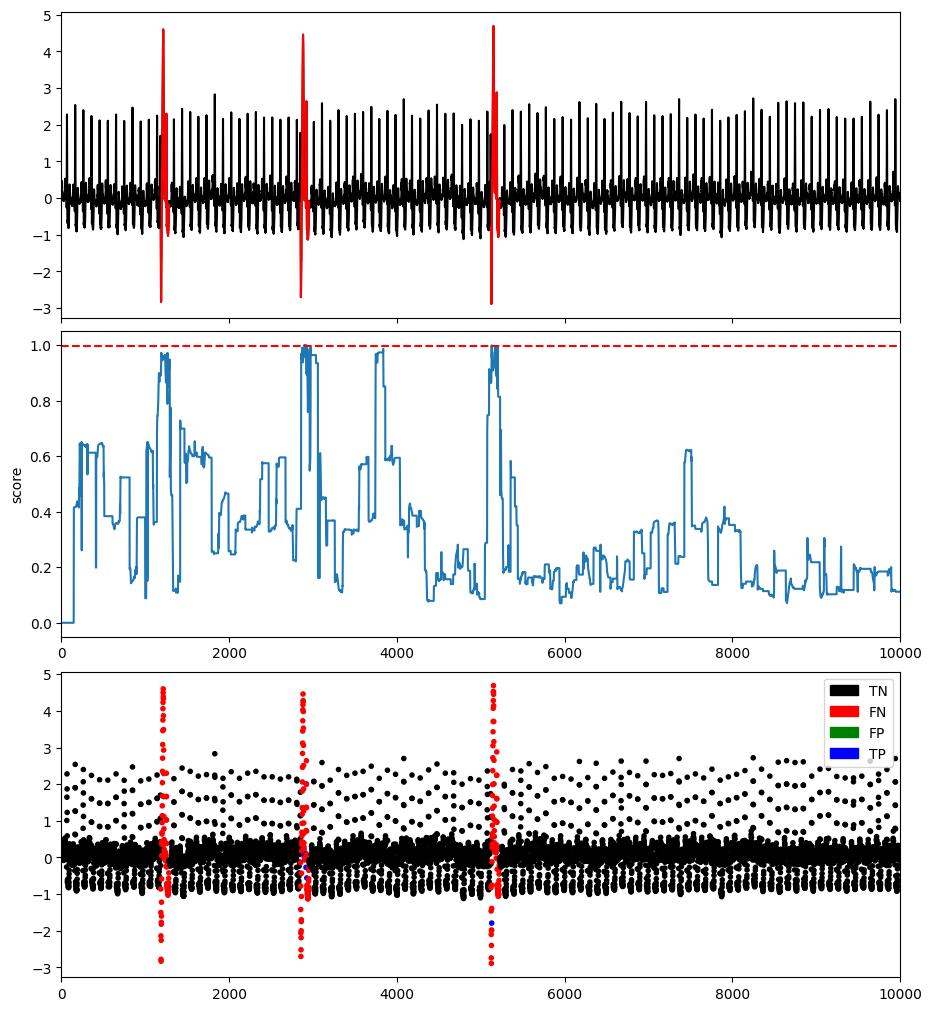

In [4]:
modelName='DAMP'
clf = DAMP(m = slidingWindow,sp_index=slidingWindow+1)
x = data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

AUC_ROC : 0.9959481871668655
AUC_PR : 0.8692027837599462
Precision : 0.7186700767263428
Recall : 0.9273927392739274
F : 0.8097982708933718
Precision_at_k : 0.9273927392739274
Rprecision : 0.7187604789238021
Rrecall : 0.9420083184789068
RF : 0.8153794209031304
R_AUC_ROC : 0.999583322571135
R_AUC_PR : 0.9885735033146819
VUS_ROC : 0.9990629917151671
VUS_PR : 0.9734561453413322
Affiliation_Precision : 0.9828122563482525
Affiliation_Recall : 0.9999994517742231


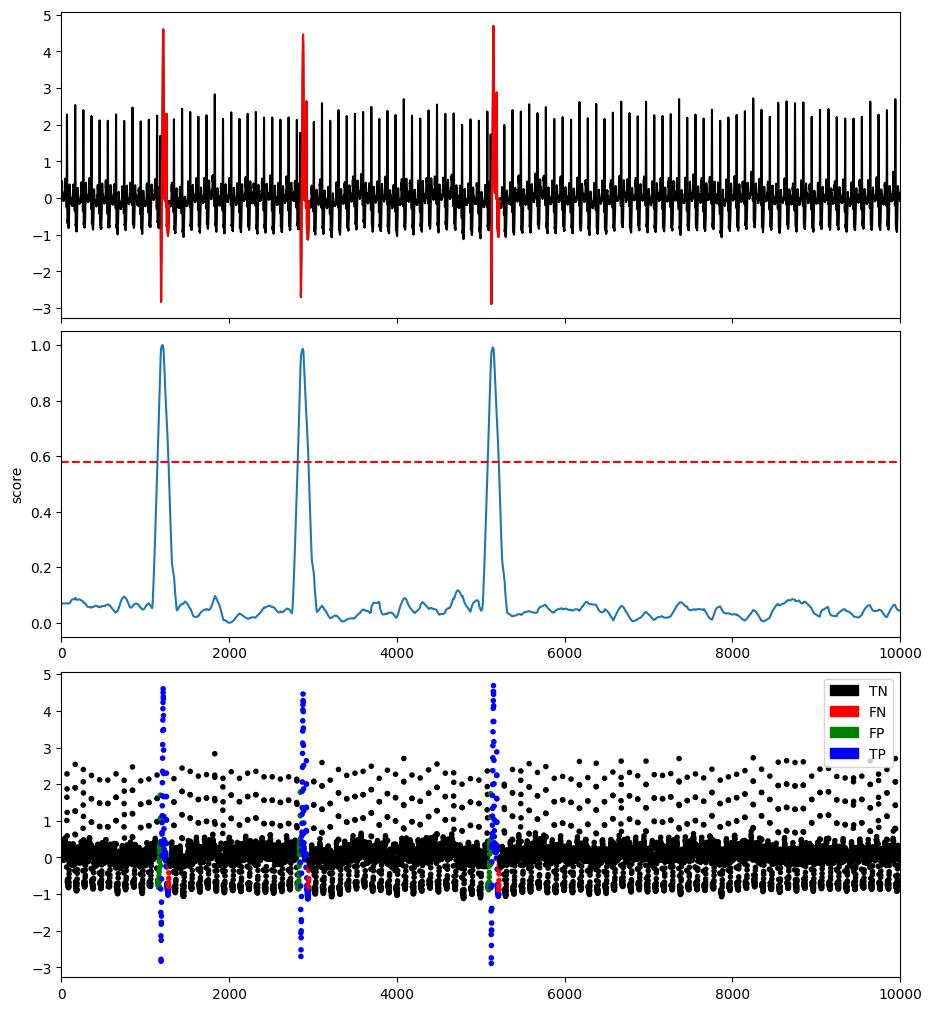

In [5]:
modelName='SAND (offline)'
clf = SAND(pattern_length=slidingWindow,subsequence_length=4*(slidingWindow))
x = data
clf.fit(x,overlaping_rate=int(1.5*slidingWindow))
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

0-->5000-->7000-->9000-->[STOP]: score length 10000
AUC_ROC : 0.9954870190535605
AUC_PR : 0.8596417688350351
Precision : 0.5923566878980892
Recall : 0.9207920792079208
F : 0.7209302325581395
Precision_at_k : 0.9207920792079208
Rprecision : 0.627737337591129
Rrecall : 0.9370964547435138
RF : 0.7518375899706807
R_AUC_ROC : 0.9984754824868738
R_AUC_PR : 0.9674524718205894
VUS_ROC : 0.9981416050554184
VUS_PR : 0.9561962341246354
Affiliation_Precision : 0.9769233832034803
Affiliation_Recall : 0.9999994517742231


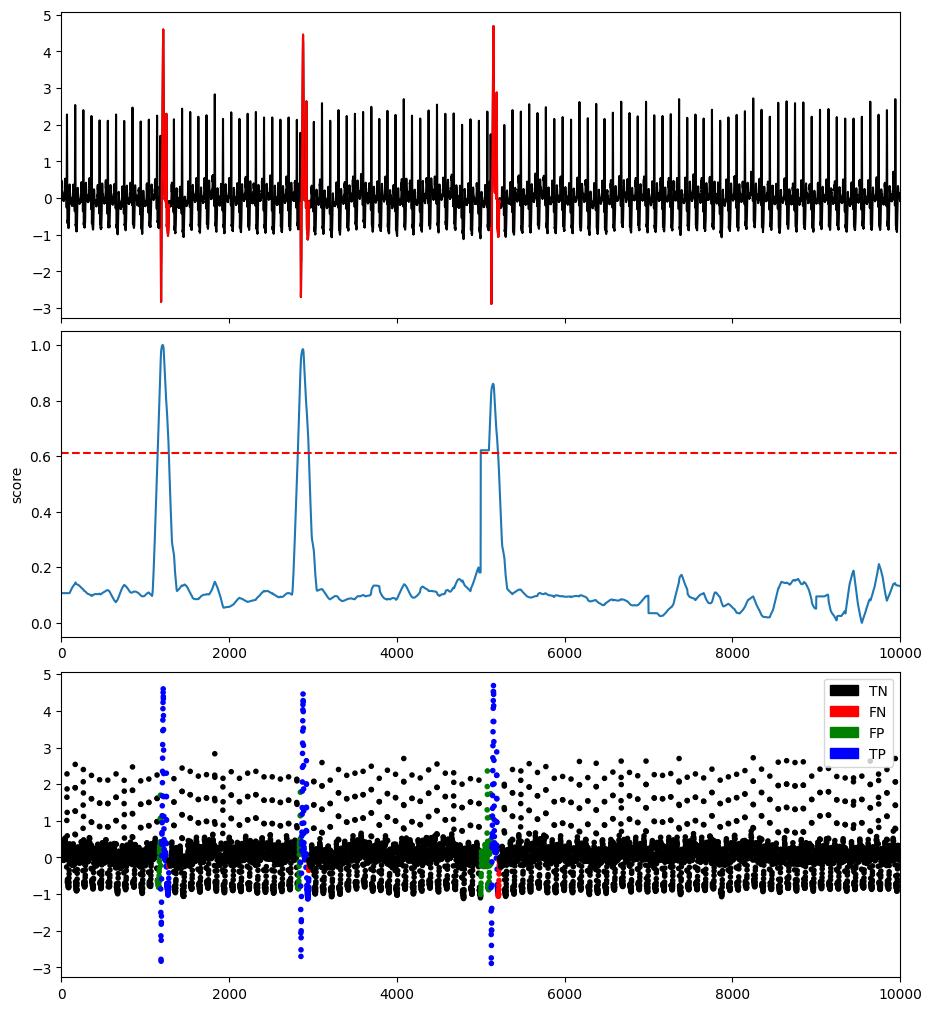

In [6]:
modelName='SAND (online)'
clf = SAND(pattern_length=slidingWindow,subsequence_length=4*(slidingWindow))
x = data
clf.fit(x,online=True,alpha=0.5,init_length=5000,batch_size=2000,verbose=True,overlaping_rate=int(4*slidingWindow))
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

AUC_ROC : 0.9791393752142049
AUC_PR : 0.8207550472208245
Precision : 0.7847222222222222
Recall : 0.7458745874587459
F : 0.7648054145516074
Precision_at_k : 0.7458745874587459
Rprecision : 0.4783287995269071
Rrecall : 0.796712220241632
RF : 0.5977696308872898
R_AUC_ROC : 0.9839017047884915
R_AUC_PR : 0.8408434964392455
VUS_ROC : 0.978472608857905
VUS_PR : 0.8203200675085416
Affiliation_Precision : 0.9282931033407741
Affiliation_Recall : 0.9989565215573869


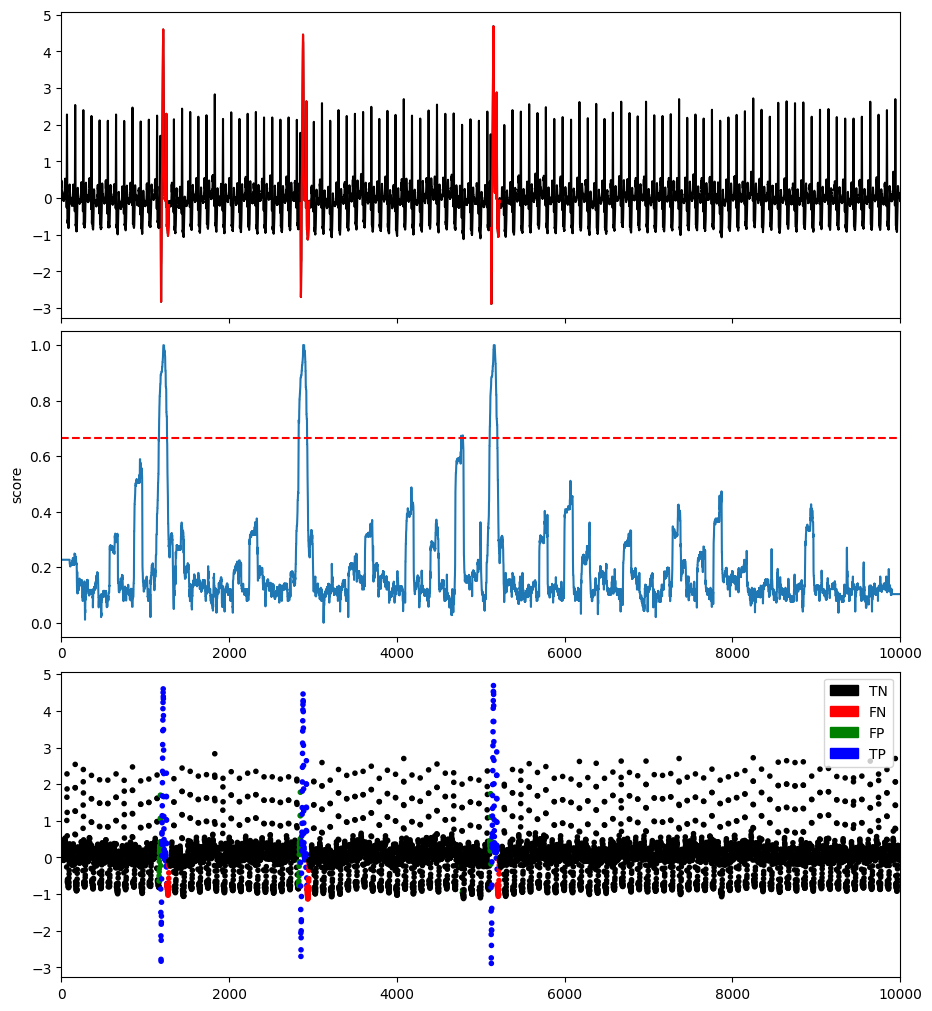

In [7]:
modelName='Series2Graph'
clf = Series2Graph(pattern_length=slidingWindow)
x = data
clf.fit(x)
query_length = slidingWindow*2
clf.score(query_length=query_length,dataset=data)
score = clf.decision_scores_
score = np.array([score[0]]*math.ceil(query_length//2) + list(score) + [score[-1]]*(query_length//2))
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])


AUC_ROC : 0.9864600361242684
AUC_PR : 0.7464228538899021
Precision : 0.78
Recall : 0.7722772277227723
F : 0.7761194029850748
Precision_at_k : 0.7722772277227723
Rprecision : 0.3952721088435374
Rrecall : 0.8178649237472767
RF : 0.5329640172113774
R_AUC_ROC : 0.999425364203696
R_AUC_PR : 0.983420960469445
VUS_ROC : 0.9975283459666097
VUS_PR : 0.9481716391214214
Affiliation_Precision : 0.989055558098137
Affiliation_Recall : 0.9979668382631797


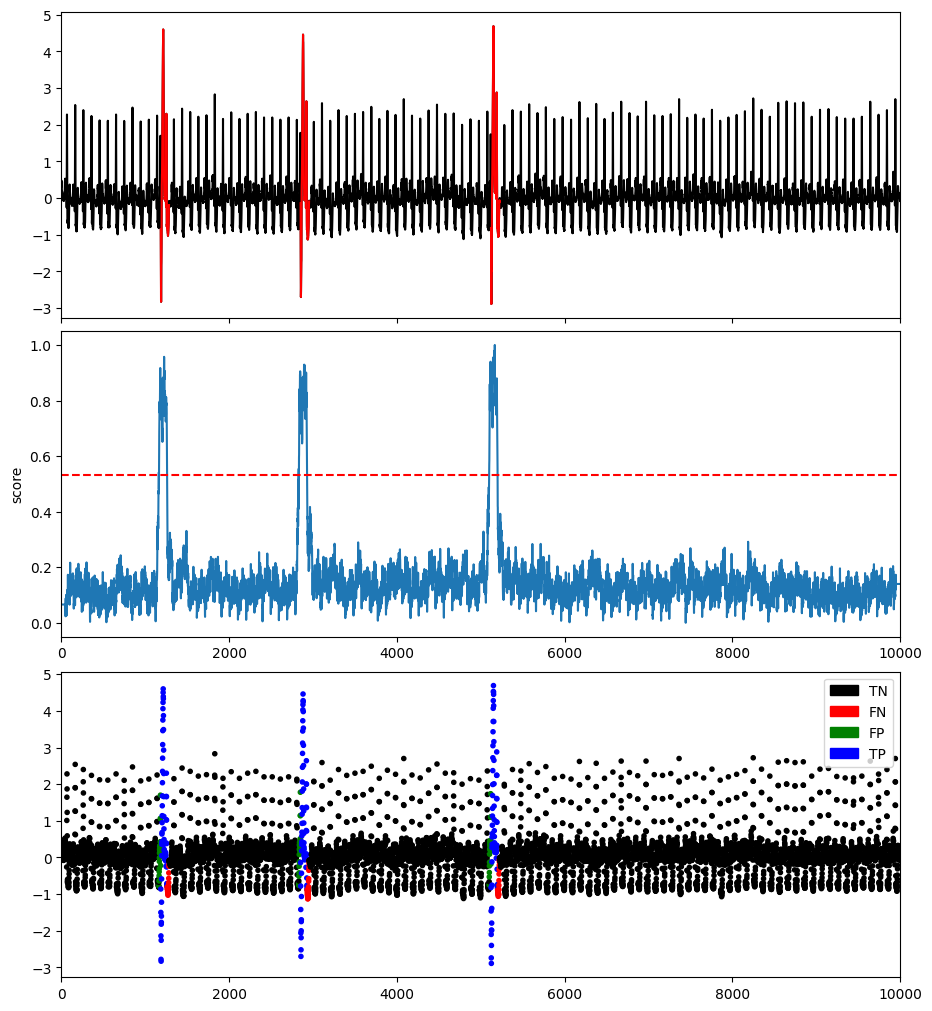

In [8]:
modelName='IForest'
clf = IForest(n_jobs=1)
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) 

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

AUC_ROC : 0.41096068975774547
AUC_PR : 0.048104473111295544
Precision : 0.21794871794871795
Recall : 0.16831683168316833
F : 0.1899441340782123
Precision_at_k : 0.16831683168316833
Rprecision : 0.3095238095238095
Rrecall : 0.304812834224599
RF : 0.3071502590673575
R_AUC_ROC : 0.6916553096198312
R_AUC_PR : 0.4549204085910081
VUS_ROC : 0.6545868021121983
VUS_PR : 0.35228784121262147
Affiliation_Precision : 0.942248287092041
Affiliation_Recall : 0.978882103900466


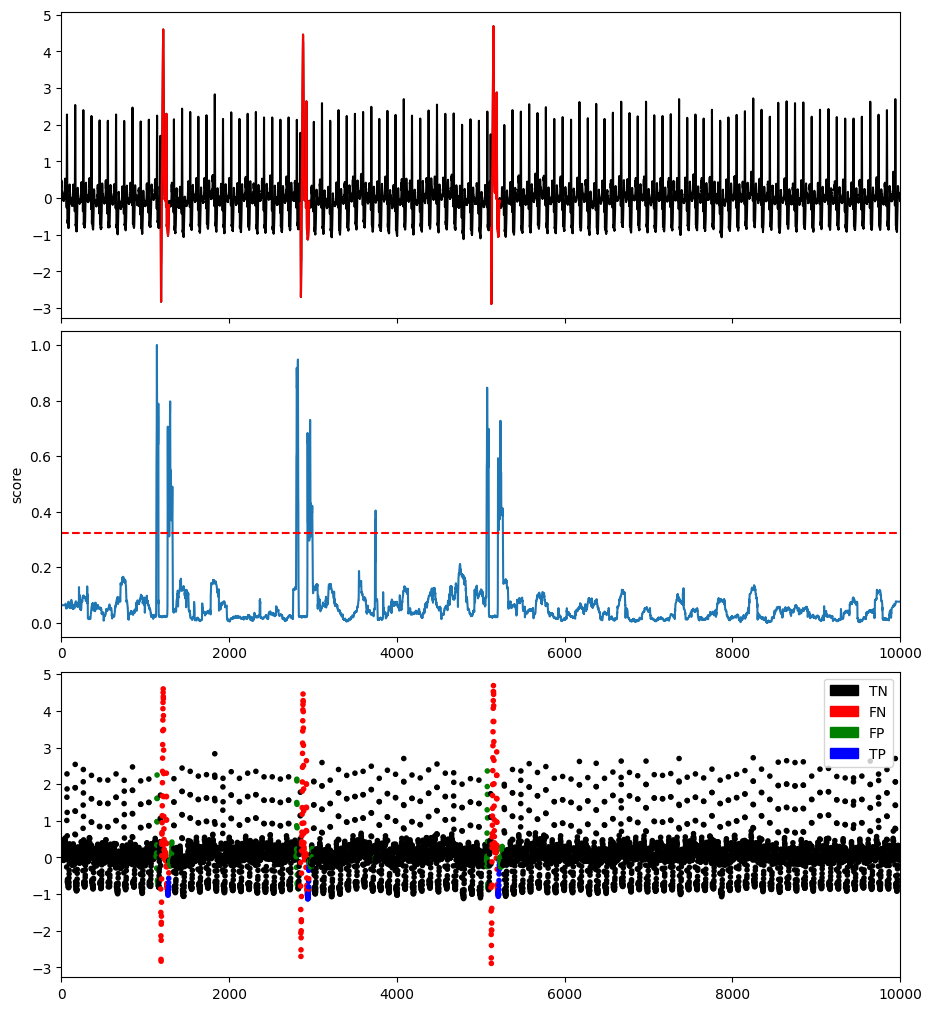

In [9]:
modelName='LOF'
clf = LOF(n_neighbors=20, n_jobs=1)
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) 

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

AUC_ROC : 0.7968186887782313
AUC_PR : 0.09205761752802392
Precision : 0.058823529411764705
Recall : 0.0297029702970297
F : 0.039473684210526314
Precision_at_k : 0.0297029702970297
Rprecision : 0.125
Rrecall : 0.09090909090909093
RF : 0.10526315789473685
R_AUC_ROC : 0.9531611224056705
R_AUC_PR : 0.4926688922361494
VUS_ROC : 0.9186620929224953
VUS_PR : 0.39033909329157723
Affiliation_Precision : 0.9015749833720904
Affiliation_Recall : 0.9720951147963328


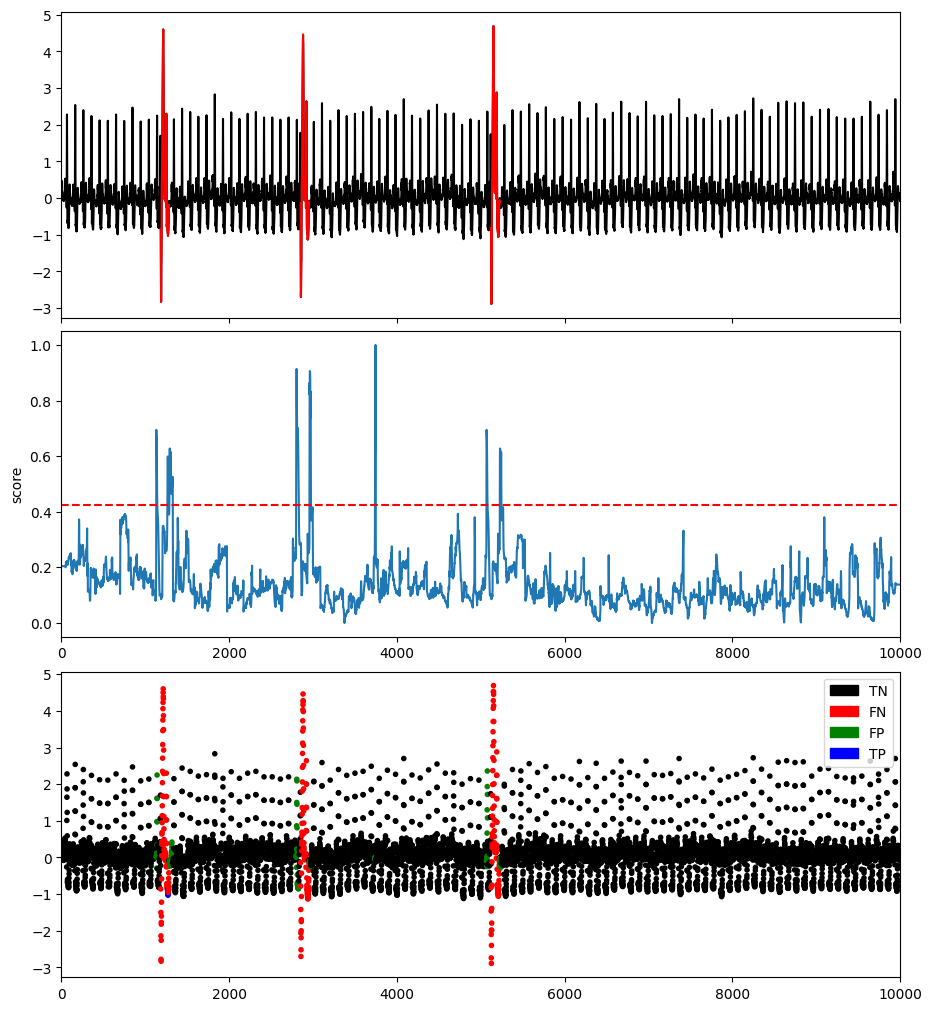

In [10]:
modelName='MatrixProfile'
clf = MatrixProfile(window = slidingWindow)
x = data
clf.fit(x)
score = clf.decision_scores_

score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

Normal Model Length/number of subsequences selected:  (297, 10)
AUC_ROC : 0.9979623516646807
AUC_PR : 0.932388006170981
Precision : 0.753731343283582
Recall : 1.0
F : 0.8595744680851063
Precision_at_k : 1.0
Rprecision : 0.7537313432835822
Rrecall : 1.0000000000000002
RF : 0.8595744680851066
R_AUC_ROC : 0.9997724221201816
R_AUC_PR : 0.994024737583278
VUS_ROC : 0.999568694352888
VUS_PR : 0.988052538139092
Affiliation_Precision : 0.9812433853440004
Affiliation_Recall : 1.0


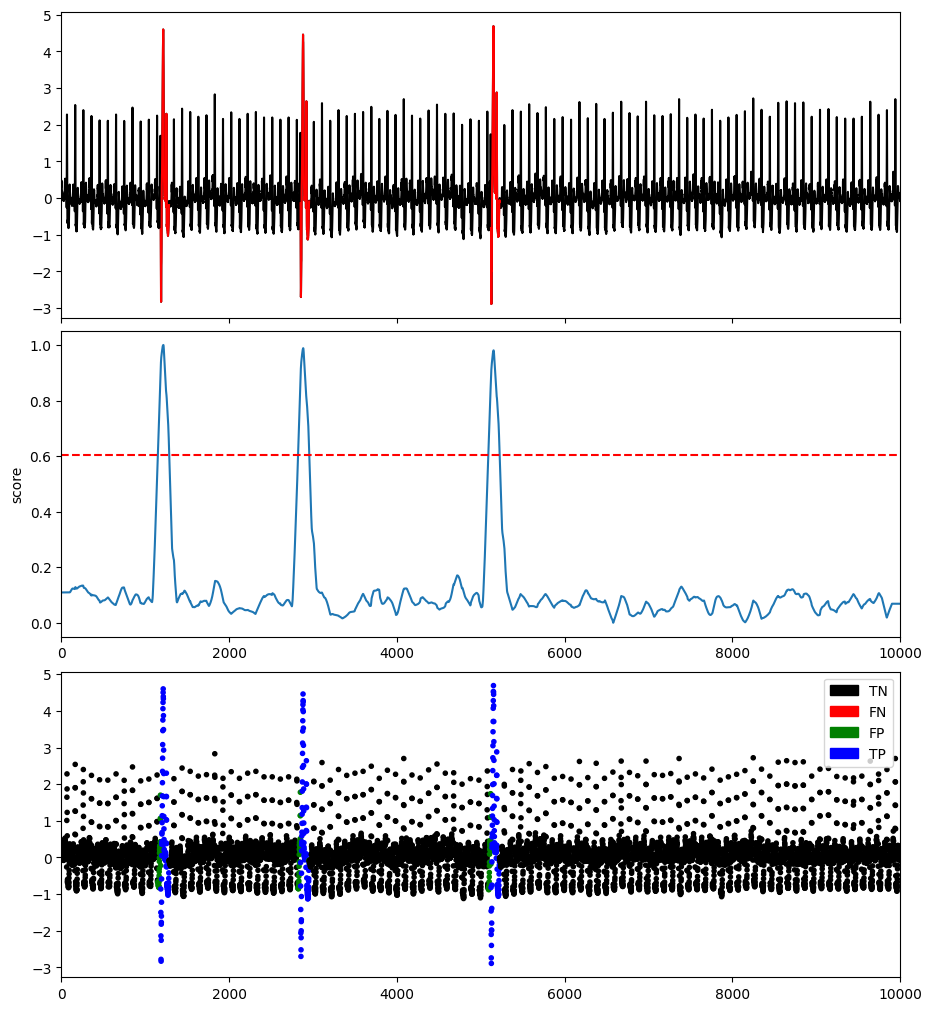

In [11]:
modelName='NORMA'
clf = NORMA(pattern_length = slidingWindow, nm_size=3*slidingWindow)
x = data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*((slidingWindow-1)//2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

AUC_ROC : 0.9831757023284056
AUC_PR : 0.7572161269856095
Precision : 0.7752442996742671
Recall : 0.7854785478547854
F : 0.7803278688524591
Precision_at_k : 0.7854785478547854
Rprecision : 0.77530626365804
Rrecall : 0.8284808873044168
RF : 0.8010120555743515
R_AUC_ROC : 0.9994595750446229
R_AUC_PR : 0.9836739288859631
VUS_ROC : 0.997118940672939
VUS_PR : 0.9475589866373976
Affiliation_Precision : 0.9890337001400605
Affiliation_Recall : 0.9982808225194953


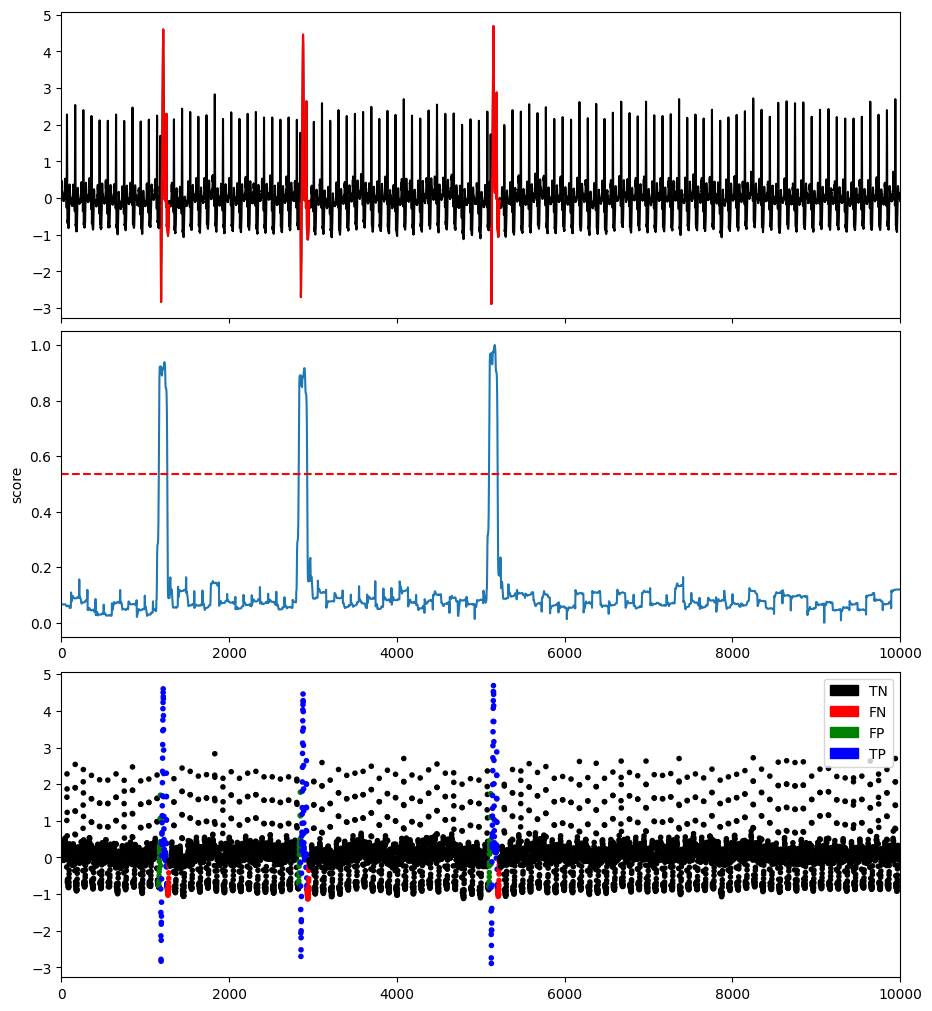

In [12]:
modelName='PCA'
clf = PCA()
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

AUC_ROC : 0.9958617394172128
AUC_PR : 0.8837102941063337
Precision : 0.8686868686868687
Recall : 0.8514851485148515
F : 0.86
Precision_at_k : 0.8514851485148515
Rprecision : 0.8686868686868686
Rrecall : 0.8821944939591999
RF : 0.875388577295774
R_AUC_ROC : 0.9966496859473177
R_AUC_PR : 0.9632279391916059
VUS_ROC : 0.9939772090687404
VUS_PR : 0.9465631009222253
Affiliation_Precision : 0.9810555530560522
Affiliation_Recall : 0.9999934905686477


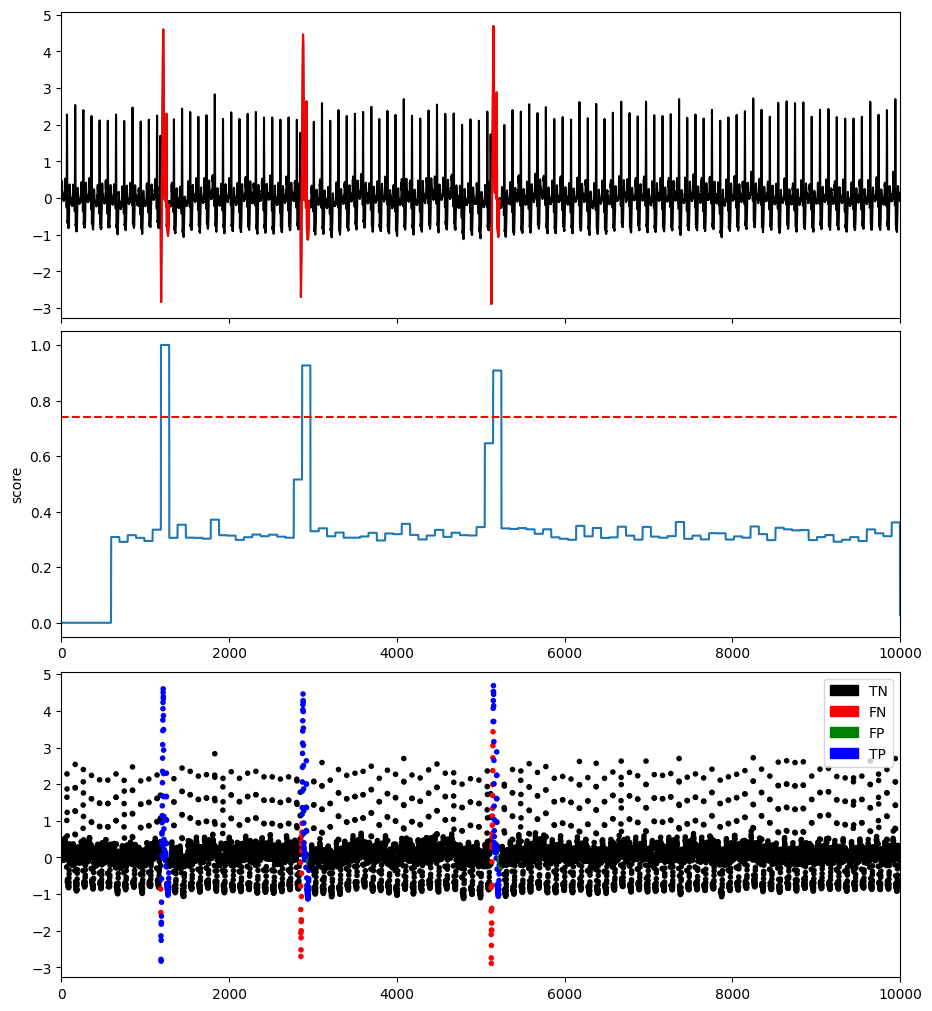

In [13]:
modelName='POLY'
clf = POLY(power=3, window = slidingWindow)
x = data
clf.fit(x)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

AUC_ROC : 0.9416967787322199
AUC_PR : 0.4592289027872978
Precision : 0.6402266288951841
Recall : 0.7458745874587459
F : 0.6890243902439025
Precision_at_k : 0.7458745874587459
Rprecision : 0.4007206588881263
Rrecall : 0.7967914438502675
RF : 0.5332568942659819
R_AUC_ROC : 0.9983442451461604
R_AUC_PR : 0.9119783238745204
VUS_ROC : 0.9905101824629529
VUS_PR : 0.8021253491270806
Affiliation_Precision : 0.9798093961448288
Affiliation_Recall : 0.9970749874410433


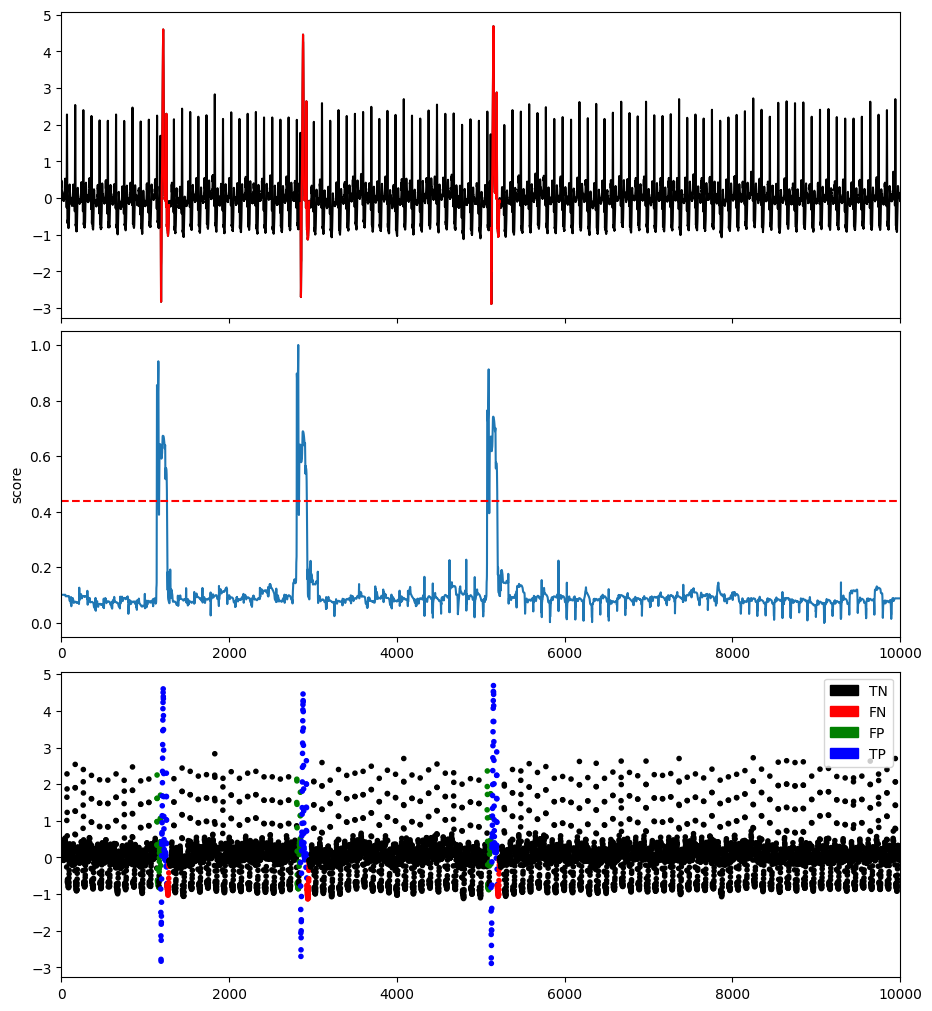

In [14]:
modelName='OCSVM'
X_train_ = MinMaxScaler(feature_range=(0,1)).fit_transform(X_train.T).T
X_test_ = MinMaxScaler(feature_range=(0,1)).fit_transform(X_test.T).T

clf = OCSVM(nu=0.05)
clf.fit(X_train_, X_test_)


score = clf.decision_scores_
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

310/310 [==============================] - 2s 7ms/step
AUC_ROC : 0.7012801414203501
AUC_PR : 0.23647659272033897
Precision : 0.2222222222222222
Recall : 0.20462046204620463
F : 0.21305841924398625
Precision_at_k : 0.20462046204620463
Rprecision : 0.0410958904109589
Rrecall : 0.301010101010101
RF : 0.07231839508170199
R_AUC_ROC : 0.7356327726036788
R_AUC_PR : 0.22370813005709514
VUS_ROC : 0.7362181741402457
VUS_PR : 0.22543284967074698
Affiliation_Precision : 0.6410074191349779
Affiliation_Recall : 0.9846418850479788


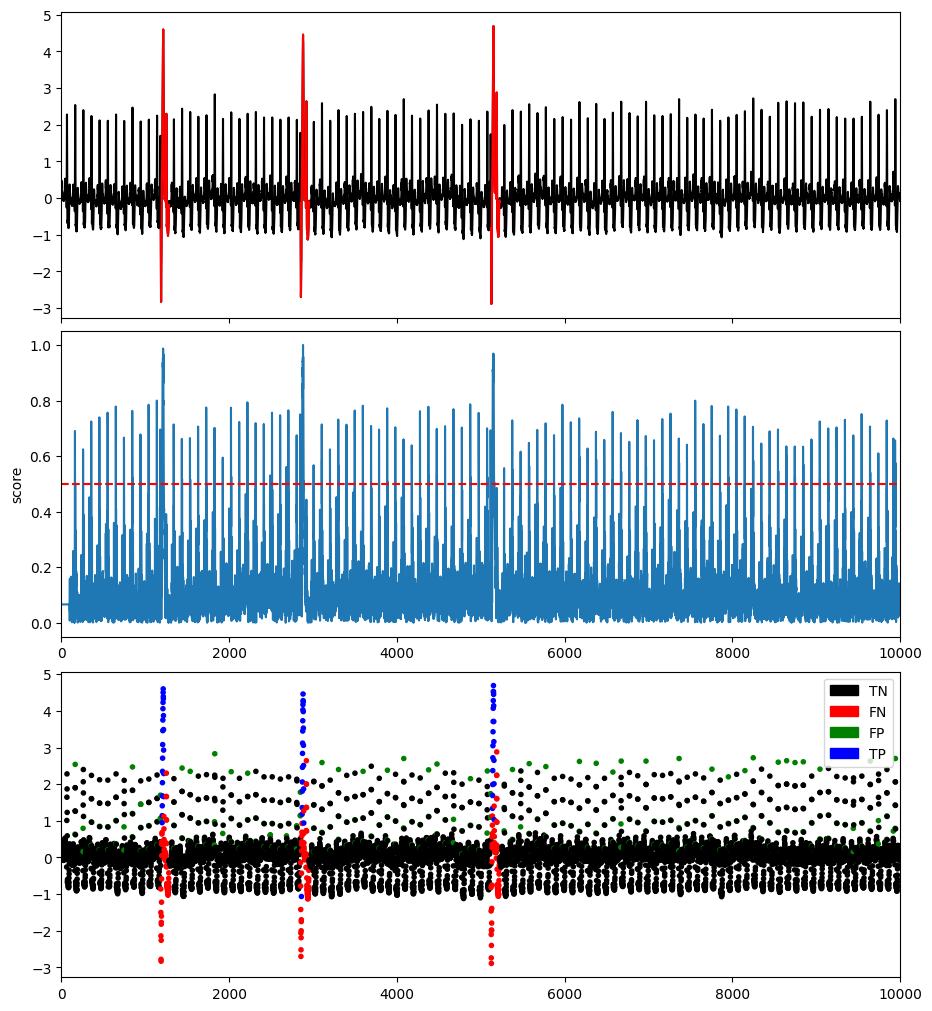

In [15]:
modelName='LSTM'
clf = lstm(slidingwindow = slidingWindow, predict_time_steps=1, epochs = 50, patience = 5, verbose=0)
clf.fit(data_train, data_test)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
        
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

310/310 [==============================] - 0s 281us/step
AUC_ROC : 0.9852191365367331
AUC_PR : 0.5282234601176695
Precision : 0.6209677419354839
Recall : 0.7623762376237624
F : 0.6844444444444445
Precision_at_k : 0.7623762376237624
Rprecision : 0.4669715447154472
Rrecall : 0.8099425628837394
RF : 0.5923971353589719
R_AUC_ROC : 0.9986094249129764
R_AUC_PR : 0.9265778571052099
VUS_ROC : 0.9960444492727658
VUS_PR : 0.8316751228768482
Affiliation_Precision : 0.9761367767263976
Affiliation_Recall : 0.9971548299870413


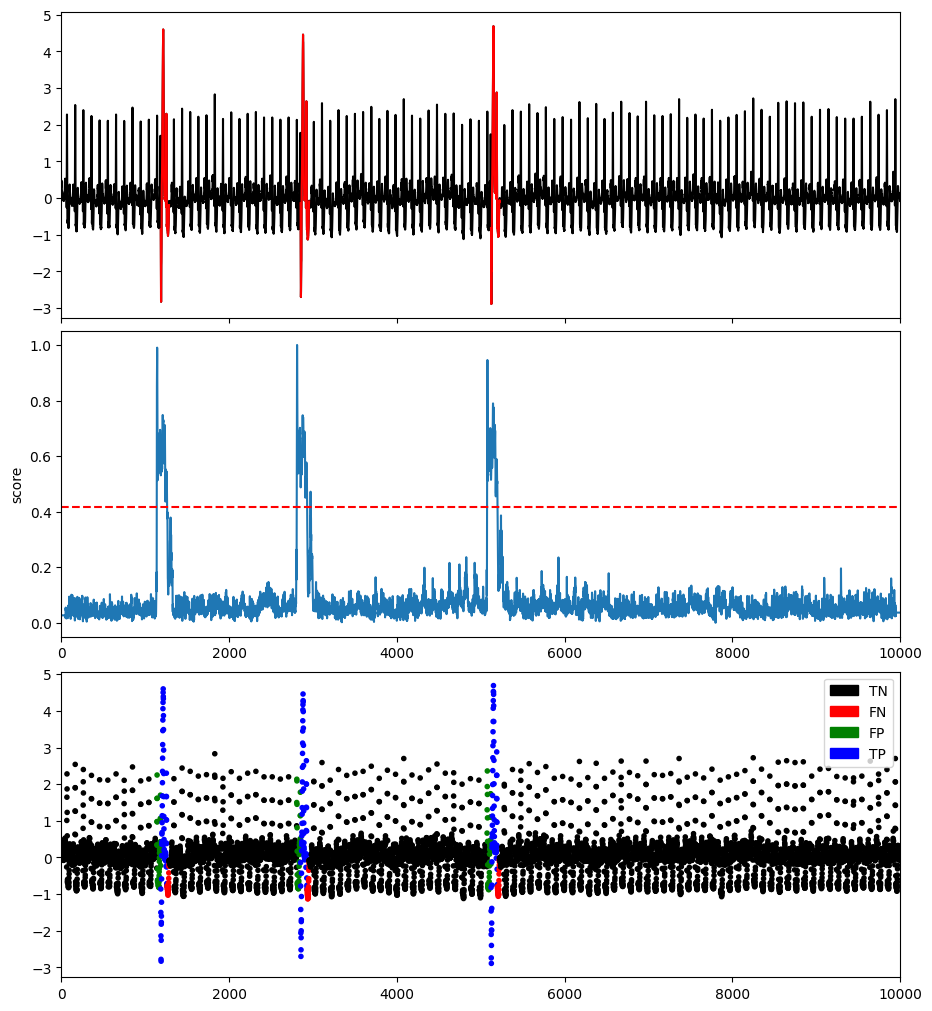

In [16]:
modelName='AE'
clf = AE_MLP2(slidingWindow = slidingWindow, epochs=100, verbose=0)

clf.fit(data_train, data_test)
        
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

310/310 [==============================] - 0s 583us/step
AUC_ROC : 0.8312461647319729
AUC_PR : 0.4094770430290849
Precision : 0.43859649122807015
Recall : 0.33003300330033003
F : 0.37664783427495285
Precision_at_k : 0.33003300330033003
Rprecision : 0.12857142857142856
Rrecall : 0.28796461345480956
RF : 0.1777710353697167
R_AUC_ROC : 0.8714286181619972
R_AUC_PR : 0.3839806015220557
VUS_ROC : 0.8743531362711117
VUS_PR : 0.40523191461062574
Affiliation_Precision : 0.896809919766213
Affiliation_Recall : 0.9902370243128832


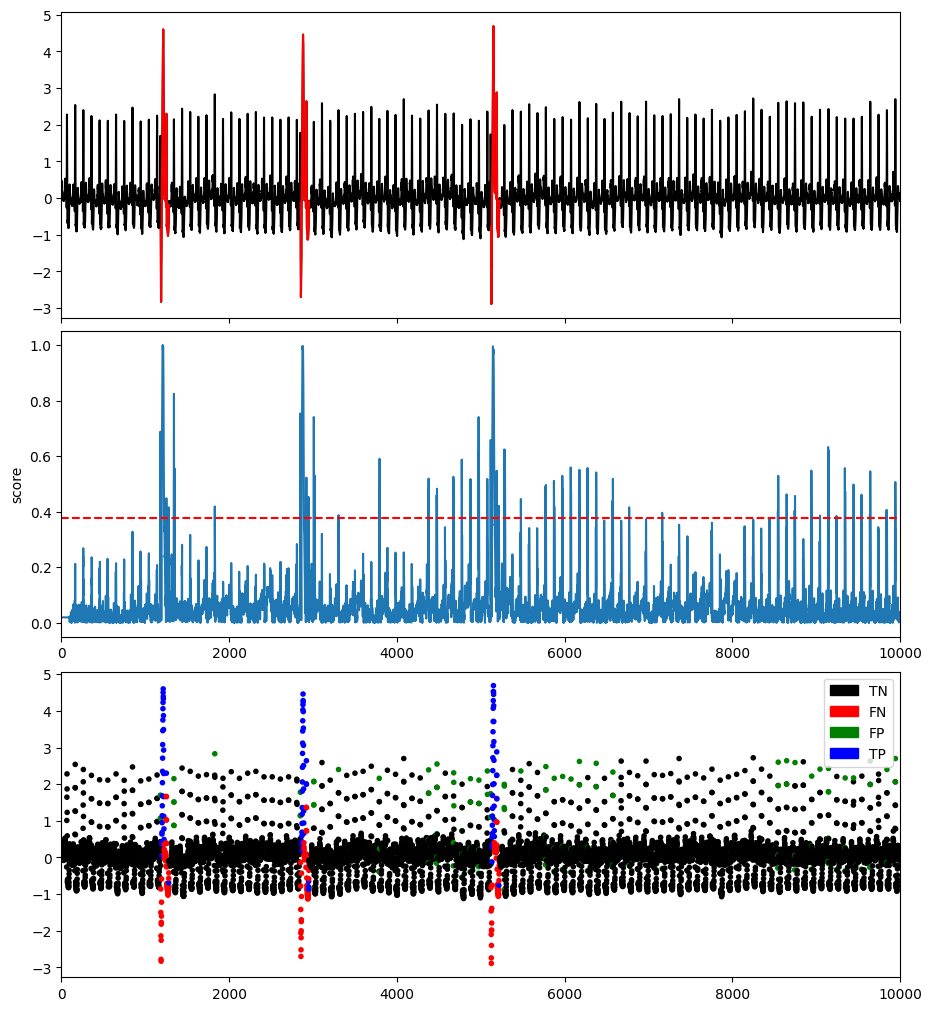

In [17]:
modelName='CNN'
clf = cnn(slidingwindow = slidingWindow, predict_time_steps=1, epochs = 100, patience = 5, verbose=0)

clf.fit(data_train, data_test)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])